In [ ]:
import json
import pandas as pd
import requests
import re
import os 
from dotenv import load_dotenv
load_dotenv()
root = os.getenv('PROJECT_ROOT')

In [ ]:
with open(os.path.join(root, 'data/metadata.jsonl'), 'r', encoding='utf-8') as f:
    lines = [json.loads(line) for line in f]

In [66]:
df = pd.DataFrame(lines)
df.head()

,task_id,Question,Level,Final answer,file_name,Annotator Metadata
0,c61d22de-5f6c-4958-a7f6-5e9707bd3466,A paper about AI regulation that was originall...,2,egalitarian,,{'Steps': '1. Go to arxiv.org and navigate to ...
1,17b5a6a3-bc87-42e8-b0fb-6ab0781ef2cc,I’m researching species that became invasive a...,2,34689,,{'Steps': '1. Search the web for “finding nemo...
2,04a04a9b-226c-43fd-b319-d5e89743676f,If we assume all articles published by Nature ...,2,41,,{'Steps': '1. Find how many articles were publ...
3,14569e28-c88c-43e4-8c32-097d35b9a67d,"In Unlambda, what exact charcter or text needs...",2,backtick,,"{'Steps': '1. Searched ""Unlambda syntax"" onlin..."
4,e1fc63a2-da7a-432f-be78-7c4a95598703,If Eliud Kipchoge could maintain his record-ma...,1,17,,{'Steps': '1. Googled Eliud Kipchoge marathon ...


In [ ]:
df.query('Level == 1').head(10)

In [ ]:
BASE_URL = "https://agents-course-unit4-scoring.hf.space/"
r = requests.get(BASE_URL + "/questions")
pd.DataFrame(r.json())

In [ ]:
BASE_URL = "https://agents-course-unit4-scoring.hf.space/"
r = requests.get(BASE_URL + "/random-question")
r.json()


In [ ]:
task_id = "cca530fc-4052-43b2-b130-b30968d8aa44"
r = requests.get(BASE_URL + f"/files/{task_id}")

r.headers
with open('./image.png', 'wb') as f:
    f.write(r.content)

In [ ]:
from PIL import Image
img = Image.open("./image.png")
display(img)

In [2]:
task_id = "8e867cd7-cff9-4е6с-867a-ff5ddc2550be"
BASE_URL = "https://agents-course-unit4-scoring.hf.space/"
r = requests.get(BASE_URL + f"/files/{task_id}")

r.headers
with open('./image.png', 'wb') as f:
    f.write(r.content)

In [6]:
df.query(f"task_id == '{task_id}'")

,task_id,Question,Level,Final answer,file_name,Annotator Metadata


# Find total tools may needed

regex + GPT analysis

In [7]:
with open('./data/metadata.jsonl', 'r', encoding='utf-8') as f:
    lines = [json.loads(line) for line in f]
lines[0]

{'task_id': 'c61d22de-5f6c-4958-a7f6-5e9707bd3466',
 'Question': 'A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure with three axes, where each axis has a label word at both ends. Which of these words is used to describe a type of society in a Physics and Society article submitted to arXiv.org on August 11, 2016?',
 'Level': 2,
 'Final answer': 'egalitarian',
 'file_name': '',
 'Annotator Metadata': {'Steps': '1. Go to arxiv.org and navigate to the Advanced Search page.\n2. Enter "AI regulation" in the search box and select "All fields" from the dropdown.\n3. Enter 2022-06-01 and 2022-07-01 into the date inputs, select "Submission date (original)", and submit the search.\n4. Go through the search results to find the article that has a figure with three axes and labels on each end of the axes, titled "Fairness in Agreement With European Values: An Interdisciplinary Perspective on AI Regulation".\n5. Note the six words used as labels: deon

In [39]:
tools = set()
with open('./data/metadata.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line)
        if "Tools" in data["Annotator Metadata"]:
            tool_lst = re.findall(r"\d+\.\s*([^\n(]+)\s+", data["Annotator Metadata"]['Tools'])
            tools.update(tool_lst)
            
tools_string = "|".join(list(tools))

In [46]:
from openai import OpenAI  # 新版 client
client = OpenAI()

In [56]:
BASIC_PROMPT = """\
    Extract only the tool names from the numbered list below.
    Ignore any description in parentheses or after a newline.
    Return the answer strictly as a JSON array of strings.

    Numbered list:
    {payload}
    """

def extract_unique_tools(tool_string: str, model: str = "gpt-3.5-turbo") -> list:
    response = client.chat.completions.create(
        model=model,
        temperature=0,               # 抽取任务用 0 可减少随机性
        messages=[
            {"role": "system",
             "content": "You are an assistant that extracts tool names from text."},
            {"role": "user", "content": BASIC_PROMPT.format(payload=tools_string)}
        ],
        response_format={"type": "json_object"}
    )
    content = json.loads(response.choices[0].message.content.strip())
    
    
    # 安全解析返回的 Python list 字符串
    try:
        tool_list = content["tool_names"]
        if isinstance(tool_list, list):
            return tool_list
        else:
            raise ValueError("Output is not a list")
    except Exception as e:
        print("⚠️ Failed to parse GPT output:", content)
        return []
    
    # return json.loads(content)       # 若格式不合法会抛异常
    
tools = extract_unique_tools(tools_string)

In [57]:
tools

['PDF',
 'C++ compiler',
 'Unlambda compiler',
 'Calculator',
 'Image processing tools',
 'Image recognition and processing',
 'Text',
 'Search Engine',
 'XLSX file',
 'XML file access',
 'Excel file access',
 'computer algebra',
 'Bass note data',
 'A speech-to-text',
 'Audio',
 'Image',
 'Web',
 'JSONLD file',
 'Word document',
 'Access to Google Maps',
 'Computer vision or OCR',
 'YouTube',
 'CSV file access',
 'Spreadsheet',
 'Microsoft Excel',
 'PowerPoint',
 'A Python IDE',
 'Access to Wikipedia',
 'PDF viewer',
 'YouTube player',
 'Tool to extract text from',
 'PDF access',
 'Python',
 'Computer vision',
 'Video',
 'Web Browser',
 'Google Translate',
 'Access to the Internet Archive, web.archive.org',
 'Access to academic journal',
 'Color recognition',
 'Text processing/diff',
 'OCR',
 'Calculator or counting',
 'Python compiler',
 "Rubik's cube",
 'GIF parsing',
 'File handling',
 'A speech-to-text audio processing',
 'Excel',
 'Access to YouTube',
 'PDF reader']

# Write retriever

In [ ]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings

In [7]:
metadata_path = "./data/metadata.jsonl"
documents = []
contents = []
with open(metadata_path, "r", encoding='utf-8') as f:
    for line in f:
        item = json.loads(line)
        questions = item['Question']
        steps = item['Annotator Metadata'].get('Steps', "")
        final_answer = item['Final answer']            
        content = f"{questions}\n\n{steps}\n\nFinal Answer: {final_answer}"
        contents.append(content)
        metadata = {
            "task_id": item.get("task_id", ""),
            "level": item.get("Level", ""),
            "final_answer": item.get("Final answer", ""),
            "num_steps": item["Annotator Metadata"].get("Number of steps", ""),
            "tools": item["Annotator Metadata"].get("Tools", ""),
            "num_tools": item["Annotator Metadata"].get("Number of tools", ""),
            "time_taken": item["Annotator Metadata"].get("How long did this take?"),
        }
        documents.append(Document(page_content=content, metadata=metadata))
documents

[Document(metadata={'task_id': 'c61d22de-5f6c-4958-a7f6-5e9707bd3466', 'level': 2, 'final_answer': 'egalitarian', 'num_steps': '12', 'tools': '1. Web browser\n2. Image recognition tools (to identify and parse a figure with three axes)', 'num_tools': '2', 'time_taken': '8 minutes'}, page_content='A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure with three axes, where each axis has a label word at both ends. Which of these words is used to describe a type of society in a Physics and Society article submitted to arXiv.org on August 11, 2016?\n\n1. Go to arxiv.org and navigate to the Advanced Search page.\n2. Enter "AI regulation" in the search box and select "All fields" from the dropdown.\n3. Enter 2022-06-01 and 2022-07-01 into the date inputs, select "Submission date (original)", and submit the search.\n4. Go through the search results to find the article that has a figure with three axes and labels on each end of the axes, titled "Fair

In [21]:
import weaviate
from weaviate.classes.init import Auth
import os 
from dotenv import load_dotenv
load_dotenv()
from langchain_weaviate.vectorstores import WeaviateVectorStore
from langchain_openai import OpenAIEmbeddings

In [20]:
weaviate_client = weaviate.connect_to_weaviate_cloud(
    cluster_url=os.getenv("WEAVIATE_URL"),
    auth_credentials=Auth.api_key(os.getenv("WEAVIATE_API_KEY"))
)

/Users/yuwensun/Documents/Agent/Final_Assignment_Template/.venv/lib/python3.9/site-packages/weaviate/warnings.py:232: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(
/var/folders/24/_vwy2y0n10scfhkf8kb16hmm0000gn/T/ipykernel_41490/3566112166.py:1: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.1.6', 58456), raddr=('34.36.172.118', 443)>
  weaviate_client = weaviate.connect_to_weaviate_cloud(


In [22]:
db = WeaviateVectorStore.from_documents(documents, OpenAIEmbeddings(), client=weaviate_client)

In [23]:
query = "What did the president say about Ketanji Brown Jackson"
docs = db.similarity_search(query)

In [24]:
docs

[Document(metadata={'tools': 'Web Browser', 'task_id': UUID('ed58682d-bc52-4baa-9eb0-4eb81e1edacc'), 'level': 2.0, 'num_tools': '1', 'final_answer': 'stare', 'time_taken': '20 minutes', 'num_steps': '12'}, page_content='What is the last word before the second chorus of the King of Pop\'s fifth single from his sixth studio album?\n\n1. Google searched "King of Pop".\n2. Clicked on Michael Jackson\'s Wikipedia.\n3. Scrolled down to "Discography".\n4. Clicked on the sixth album, "Thriller".\n5. Looked under "Singles from Thriller".\n6. Clicked on the fifth single, "Human Nature".\n7. Google searched "Human Nature Michael Jackson Lyrics".\n8. Looked at the opening result with full lyrics sourced by Musixmatch.\n9. Looked for repeating lyrics to determine the chorus.\n10. Determined the chorus begins with "If they say" and ends with "Does he do me that way?"\n11. Found the second instance of the chorus within the lyrics.\n12. Noted the last word before the second chorus - "stare".\n\nFinal 

In [77]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from tqdm import tqdm

In [86]:
contents

['A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure with three axes, where each axis has a label word at both ends. Which of these words is used to describe a type of society in a Physics and Society article submitted to arXiv.org on August 11, 2016?\n\n1. Go to arxiv.org and navigate to the Advanced Search page.\n2. Enter "AI regulation" in the search box and select "All fields" from the dropdown.\n3. Enter 2022-06-01 and 2022-07-01 into the date inputs, select "Submission date (original)", and submit the search.\n4. Go through the search results to find the article that has a figure with three axes and labels on each end of the axes, titled "Fairness in Agreement With European Values: An Interdisciplinary Perspective on AI Regulation".\n5. Note the six words used as labels: deontological, egalitarian, localized, standardized, utilitarian, and consequential.\n6. Go back to arxiv.org\n7. Find "Physics and Society" and go to the page for 

In [87]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)
embeddings = embedder.encode(
    contents,
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True  # 归一化后可用 cosine 距离
)

Batches: 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]


array([[-0.01155405, -0.00915914, -0.10085999, ...,  0.05214797,
        -0.00451089, -0.02103698],
       [-0.04111664,  0.02944613, -0.04484621, ...,  0.00970147,
        -0.02912554,  0.07563014],
       [ 0.06093967,  0.09861611,  0.05144812, ..., -0.10613946,
        -0.06369726,  0.02071095],
       ...,
       [ 0.02369183, -0.11458945,  0.04066154, ...,  0.00371408,
        -0.0762632 , -0.03941745],
       [ 0.03330699,  0.06647176,  0.13326097, ...,  0.01495302,
        -0.13716021,  0.09283056],
       [-0.07060172,  0.08127624,  0.01542982, ..., -0.06822141,
        -0.0120724 ,  0.05464282]], dtype=float32)

/Users/yuwensun/Documents/Agent/Final_Assignment_Template/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/yuwensun/Documents/Agent/Final_Assignment_Template/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/24/_vwy2y0n10scfhkf8kb16hmm0000gn/T/ipykernel_31187/2403441542.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


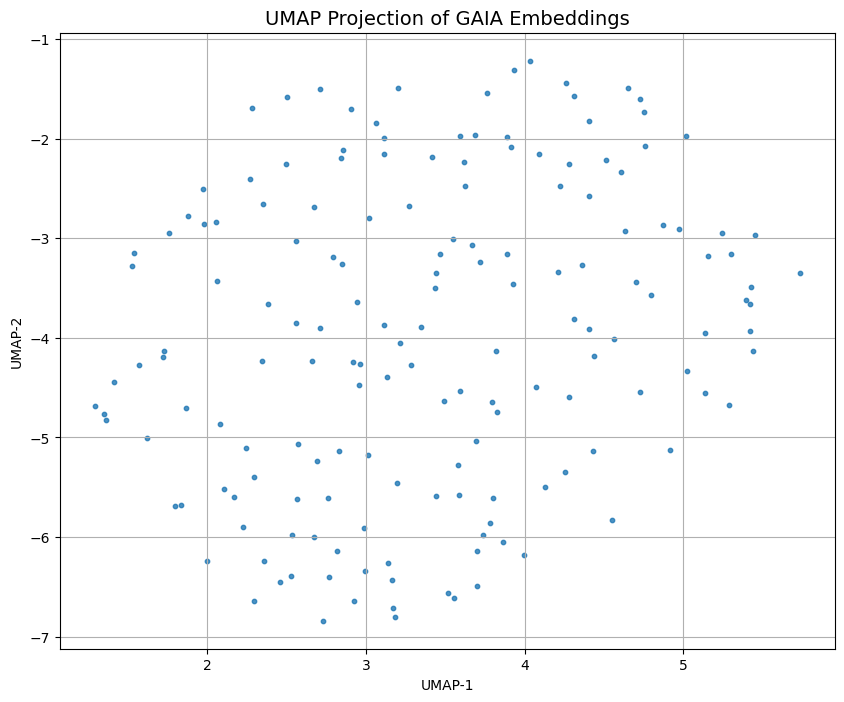

In [ ]:
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import numpy as np

# Step 1: UMAP dimensionality reduction
reducer = UMAP(
    n_neighbors=15,       # smaller = more local, higher = more global
    min_dist=0.1,         # how tightly points are packed
    n_components=2,       # 2D or 3D
    metric='cosine',      # same as you used for DBSCAN
    random_state=42
)
embedding_2d = reducer.fit_transform(embeddings)

# Step 2: Plot (2D)
plt.figure(figsize=(10, 8))
plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    s=10,
    cmap='Spectral',
    alpha=0.8
)
plt.title("UMAP Projection of GAIA Embeddings", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

# Exploration load weaviate:

In [16]:
import os 
from dotenv import load_dotenv
import weaviate
from weaviate.classes.init import Auth
from langchain_weaviate.vectorstores import WeaviateVectorStore
from langchain_openai import OpenAIEmbeddings
load_dotenv()


True

In [19]:
embeddings = OpenAIEmbeddings()
weaviate_client = weaviate.connect_to_weaviate_cloud(
    cluster_url=os.getenv("WEAVIATE_URL"),
    auth_credentials=Auth.api_key(os.getenv("WEAVIATE_API_KEY")),
)

db = WeaviateVectorStore(
    embedding=embeddings,
    client=weaviate_client,
    index_name="LangChain_f79c76034edb4cf6aec87b1f58b59e93",
    text_key="text",
)

db.similarity_search("What is the hometown of this year’s 16th overall pick in the NBA draft?")

/Users/yuwensun/Documents/Agent/agent/.venv/lib/python3.9/site-packages/weaviate/warnings.py:232: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(
/var/folders/24/_vwy2y0n10scfhkf8kb16hmm0000gn/T/ipykernel_80735/519747192.py:2: ResourceWarning: unclosed <ssl.SSLSocket fd=80, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.16.225.51', 53951), raddr=('34.36.172.118', 443)>
  weaviate_client = weaviate.connect_to_weaviate_cloud(


[Document(metadata={'task_id': UUID('c365c1c7-a3db-4d5e-a9a1-66f56eae7865'), 'num_steps': '4', 'tools': '1. Search engine\n2. Web browser', 'num_tools': '3', 'final_answer': 'Braintree, Honolulu', 'level': 1.0, 'time_taken': '8 minutes'}, page_content='Of the cities within the United States where U.S. presidents were born, which two are the farthest apart from the westernmost to the easternmost going east, giving the city names only? Give them to me in alphabetical order, in a comma-separated list\n\n1. Searched "cities where us presidents are born" on Google.\n2. Opened "List of presidents of the United States by home state" on Wikipedia.\n3. Searched the eastern cities to find the easternmost one (Braintree, MA).\n4. Checked the westernmost city (Honolulu, HI).\n\nFinal Answer: Braintree, Honolulu'),
 Document(metadata={'task_id': UUID('65da0822-a48a-4a68-bbad-8ed1b835a834'), 'num_steps': '7', 'tools': '1. Web browser\n2. Calculator', 'num_tools': '2', 'final_answer': 'Santa Clara, B

In [20]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen-qwq-32b", temperature=0) # optional : qwen-qwq-32b gemma2-9b-it

In [21]:
type(llm)

langchain_groq.chat_models.ChatGroq

In [9]:
import re
s = "FINAL ANSWER: Zhou Yu is a faculty member at Columbia University's Department of Computer Science, focusing on conversational AI, dialog systems, and natural language processing."

re.findall(r"FINAL\sANSWER: (.+)", s)[0]

"Zhou Yu is a faculty member at Columbia University's Department of Computer Science, focusing on conversational AI, dialog systems, and natural language processing."

In [10]:
print(type("dsds"))

<class 'str'>


In [13]:
"" == None

False